<font color="#CA3532"><h1 align="left">**Máster en Data Science**</h1></font>
## **PCA con Analítica de Texto**

#### Manuel Sánchez-Montañés

 Analysis of a subset of a complaints dataset using 2 classes.

In [1]:
COLAB = True

## **1. Import main libraries**

In [2]:
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

lemmatizer = WordNetLemmatizer().lemmatize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **2. Load dataset ("corpus")**

In [3]:
if COLAB:
  !mkdir datasets
  aux = "'https://docs.google.com/uc?export=download&id=13olP14Jro0vbAMVvHRQOr0rwtiRwCXZk&confirm=t'"
  !wget $aux -O ./datasets/reporting_complaints.csv.zip
  !unzip -qq ./datasets/reporting_complaints.csv.zip -d datasets


# Read the input
df = pd.read_csv("./datasets/reporting_complaints.csv") # the dataset is loaded into a Pandas DataFrame
df = df[(df["product"]=="Mortgage") | (df["product"]=="Credit card")].reset_index(drop=True)

# Para simplificar el análisis me centro en dos clases:

print(df.shape)

--2023-11-03 17:36:33--  https://docs.google.com/uc?export=download&id=13olP14Jro0vbAMVvHRQOr0rwtiRwCXZk&confirm=t
Resolving docs.google.com (docs.google.com)... 142.250.107.113, 142.250.107.139, 142.250.107.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.107.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/okdeh00p53347527l5maqof65gcejiq0/1699032975000/17112108692206476645/*/13olP14Jro0vbAMVvHRQOr0rwtiRwCXZk?e=download&uuid=f7044301-6003-43b2-8d91-2bd5ce3015ac [following]
--2023-11-03 17:36:38--  https://doc-14-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/okdeh00p53347527l5maqof65gcejiq0/1699032975000/17112108692206476645/*/13olP14Jro0vbAMVvHRQOr0rwtiRwCXZk?e=download&uuid=f7044301-6003-43b2-8d91-2bd5ce3015ac
Resolving doc-14-8k-docs.googleusercontent.com (doc-14-8k-docs.googleusercontent.com)... 142.250.107.

In [4]:
df.sample(20) # opendata.gov

,consumer_complaint_narrative,product
8451,Back in XXXX 2015 i started a loan modificatio...,Mortgage
2984,I had set up an electronic payment for my targ...,Credit card
5452,"On XXXX. XXXX, XXXX, I faxed the attached lett...",Mortgage
928,I applied for XXXX separate credit cards with ...,Credit card
7243,The mortgage company does n't pay homeowner 's...,Mortgage
9095,This matter is in regard to the foreclosure of...,Mortgage
37,I was contacting one of my credit card compani...,Credit card
6479,Sent in all the documentation required for a m...,Mortgage
156,My daughter ordered some underwear using my cr...,Credit card
9980,I have been doing research into a mortgage ref...,Mortgage


In [5]:
df['product'].value_counts()

Credit card    5000
Mortgage       5000
Name: product, dtype: int64

In [6]:
narratives = list(df['consumer_complaint_narrative'])
labels = np.array(df['product'])
print("Number of narratives: {}".format(len(narratives)))

Number of narratives: 10000


In [7]:
case = 2
print("Type of product:", labels[case])
print(narratives[case])

Type of product: Credit card
Consumer serviceMy problem is that this Synchrony Bank XXXX XXXX did not apply my payment to the higher interest account instead it was a applied to thelower interest account ( Balance before payment {$1500.00} after the payment {$590.00} ) The higher interest account did not go down remains the same {$4700.00} I have continued making the payments on this account never having any late payment. 
I had talked to the customer service dept before I made the payment they she assured me that the payment would beapplied to the higher interest account since I had already paid the payment due on the lower interest account. Needless to say they applied thefull {$1000.00} to the lower interest account. I have called them regarding this issue they explained that they had applied the payment to thehigher interest account which they did not. I sent a letter showing them prove they did not do what was promised. Hope you can helpwith this dishonest practice they want to ch

## **3. Preprocessing**

## **Training-test split**

In [8]:
from sklearn.model_selection import train_test_split

narratives_tr, narratives_te, y_tr, y_te = train_test_split(narratives, labels,
                                                            test_size=0.3, random_state=1)

print("Number of training examples: {}. Number of test examples: {}".format(len(narratives_tr), len(narratives_te)))

Number of training examples: 7000. Number of test examples: 3000


### **Creation / load of stopwords list**

In [9]:
stop_words = stopwords.words('english')
stop_words = set(stop_words) # search in sets is much faster in python

for i in range(1,21):
    stop_words.add(i*'x')
print(sorted(stop_words)) # alphabetical sort

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

### **Punctuation marks**

In [10]:
from string import punctuation
punctuation_marks = set(punctuation)
print(punctuation_marks)

{'|', '!', '^', '&', '[', ';', '_', '-', '(', ',', ':', ']', ')', '.', "'", '`', '*', '{', '=', '?', '\\', '}', '/', '$', '%', '~', '>', '"', '@', '+', '#', '<'}


In [11]:
stop_words_and_punctuation = list(stop_words.union(punctuation_marks))
print(stop_words_and_punctuation)

['these', 'when', 'have', 'xxxxxxxxxxxxx', '&', 'll', 'can', 'couldn', 'after', ';', "isn't", '_', 'with', 'myself', 'by', 'we', 'further', 'now', ']', 'because', 'don', ')', 'up', 'until', 'xxxxxxxxxxxxxxxxx', '`', 'not', 'd', "mustn't", '*', "hadn't", 'it', 'between', 'xxxxxxxxxx', 'them', 'such', 'themselves', 'this', 'should', 'all', 'an', "should've", 'shan', 'against', "weren't", '%', '>', 'yourselves', 'its', 'once', 'shouldn', 'he', '+', "shouldn't", 'him', 'i', 'doing', "hasn't", '<', 'why', 'before', 'same', 'aren', 'my', '^', 'but', 'himself', 'x', 'do', 'xxxxxx', 'from', 'other', "aren't", 'and', 'more', 'mightn', 'xxxxxxxxxxxxxxx', 'will', 's', 'her', 'am', 'into', 'too', 'wouldn', 'whom', "that'll", 'xxxxxxxxx', 'if', 'both', 'o', 'theirs', 'xxxxxxxxxxx', 'of', 'yours', 'nor', '=', 'xxxxxxxxxxxxxxxxxx', '}', 'over', '/', '$', "wasn't", "wouldn't", "doesn't", 'didn', 'won', 'has', 'does', 'hasn', 'xxxxxxxxxxxxxx', 'you', 'they', '!', 'during', '[', 'while', 'ain', 'that', 

### **Lemmatizer**

In [12]:
print(lemmatizer('song'))
print(lemmatizer('songs'))
print()
print(lemmatizer('sings'))
print(lemmatizer('sings', pos='v'))
print(lemmatizer('sings', pos='n'))

song
song

sings
sing
sings


### **Stemmer**

In [13]:
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
stemmer = PorterStemmer().stem
print(stemmer('walking'))
print(stemmer('walked'))
print(stemmer('walks'))

walk
walk
walk


In [14]:
def tokenizer(s, stop_words=[], lowercase=True,
              keep_sentences=False, min_word_len=1,
              lemmatize=False, stem=False):
    tokens = []
    if lowercase:
        s = s.lower() # downcase
    for sentence in sent_tokenize(s):
        ts = word_tokenize(sentence) # split string into words (tokens)
        ts = [t for t in ts if len(t) >= min_word_len] # remove very short words
        ts = [t for t in ts if t not in stop_words] # remove stop_words
        if lemmatize:
            ts = [lemmatizer(t) for t in ts] # put words into base form
        if stem:
            ts = [stemmer(t) for t in ts]
        if keep_sentences:
            tokens.append(ts)
        else:
            tokens.extend(ts)
    return tokens

In [15]:
case = 2
text = narratives_tr[case]
text

'I have a credit card account with Best Buy and their processing issue caused my payment to show up as late even though I provided proof that I sent the automatic payment within the needed time frame just as I had for the previous year. They have added negative items to my credit report due to their error and I would like them removed. I feel that their business practices made it so that my payment would show as late and they could collect a late fee they were not entitled too. \r\n'

In [16]:
print(tokenizer(text, keep_sentences=False), "\n")

print(tokenizer(text, stop_words=stop_words_and_punctuation,
                min_word_len = 3), "\n")

print(tokenizer(text, stop_words=stop_words_and_punctuation,
                min_word_len = 3, lemmatize=True, stem=True), "\n")

['i', 'have', 'a', 'credit', 'card', 'account', 'with', 'best', 'buy', 'and', 'their', 'processing', 'issue', 'caused', 'my', 'payment', 'to', 'show', 'up', 'as', 'late', 'even', 'though', 'i', 'provided', 'proof', 'that', 'i', 'sent', 'the', 'automatic', 'payment', 'within', 'the', 'needed', 'time', 'frame', 'just', 'as', 'i', 'had', 'for', 'the', 'previous', 'year', '.', 'they', 'have', 'added', 'negative', 'items', 'to', 'my', 'credit', 'report', 'due', 'to', 'their', 'error', 'and', 'i', 'would', 'like', 'them', 'removed', '.', 'i', 'feel', 'that', 'their', 'business', 'practices', 'made', 'it', 'so', 'that', 'my', 'payment', 'would', 'show', 'as', 'late', 'and', 'they', 'could', 'collect', 'a', 'late', 'fee', 'they', 'were', 'not', 'entitled', 'too', '.'] 

['credit', 'card', 'account', 'best', 'buy', 'processing', 'issue', 'caused', 'payment', 'show', 'late', 'even', 'though', 'provided', 'proof', 'sent', 'automatic', 'payment', 'within', 'needed', 'time', 'frame', 'previous', 'y

### **Now we preprocess all documents**

In [17]:
def preprocess_documents(texts):
    return [' '.join(tokenizer(text,
                               stop_words=stop_words_and_punctuation,
#                               lemmatize=True, stem=True,
                               min_word_len = 3))
            for text in texts]

In [18]:
examples_tr = preprocess_documents(narratives_tr)
examples_te = preprocess_documents(narratives_te)

In [19]:
case = 127

print(narratives_tr[case],"\n")
examples_tr[case]

We are working with Wells Fargo on a police and fire ( PFRS mortgage ). The mortgage broker, XXXX XXXX, XXXX Mortgage Consultant - XXXX ID XXXX, in charge of our mortgage process failed us miserably. She was n't returning phone calls, emails and then never sent the loan confirmation to our lawyer. In addition, she was n't communicating with her own underwriters. The underwriters could n't even contact her. She was n't returning their emails or phone calls. They could n't find documents that she apparently said she had sent. She chose not to step up and apologize but rather now has been dragging her feet even more. We have a closing date for XXXX XXXX. We are unsure now that we will be able to close. Very frustrated. 
 



"working wells fargo police fire pfrs mortgage mortgage broker mortgage consultant charge mortgage process failed miserably n't returning phone calls emails never sent loan confirmation lawyer addition n't communicating underwriters underwriters could n't even contact n't returning emails phone calls could n't find documents apparently said sent chose step apologize rather dragging feet even closing date unsure able close frustrated"

## **4. Bag-of-words (BOW) representation**

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
TF_vectorizer = CountVectorizer(max_features=1000, stop_words=stop_words_and_punctuation)
TF_vectorizer

CountVectorizer(max_features=1000,
                stop_words=['these', 'when', 'have', 'xxxxxxxxxxxxx', '&', 'll',
                            'can', 'couldn', 'after', ';', "isn't", '_', 'with',
                            'myself', 'by', 'we', 'further', 'now', ']',
                            'because', 'don', ')', 'up', 'until',
                            'xxxxxxxxxxxxxxxxx', '`', 'not', 'd', "mustn't",
                            '*', ...])

In [21]:
TF_vectorizer.fit(examples_tr)
tf_tr = TF_vectorizer.transform(examples_tr)
TF_vocabulary = TF_vectorizer.get_feature_names_out()

In [22]:
print(len(TF_vocabulary))
print(TF_vocabulary)

1000
['00' '10' '100' '1000' '1200' '15' '16' '200' '2000' '2013' '2014' '2015'
 '2016' '25' '300' '500' '75' 'ability' 'able' 'absolutely' 'accept'
 'accepted' 'access' 'according' 'account' 'accounting' 'accounts' 'acct'
 'accurate' 'act' 'action' 'actions' 'activity' 'actual' 'actually' 'add'
 'added' 'addition' 'additional' 'address' 'advance' 'advantage' 'advise'
 'advised' 'affected' 'afford' 'affordable' 'agencies' 'agency' 'agent'
 'ago' 'agreed' 'agreement' 'alleged' 'allow' 'allowed' 'almost' 'along'
 'already' 'also' 'although' 'always' 'america' 'american' 'amex' 'amount'
 'amounts' 'annual' 'another' 'answer' 'anyone' 'anything' 'apparently'
 'appeal' 'appears' 'application' 'applied' 'apply' 'applying' 'appraisal'
 'approval' 'approved' 'approximately' 'apr' 'around' 'ask' 'asked'
 'asking' 'assessed' 'assigned' 'assist' 'assistance' 'assured' 'attached'
 'attempt' 'attempted' 'attempting' 'attempts' 'attention' 'attorney'
 'auction' 'authorization' 'authorized' 'auto' 'a

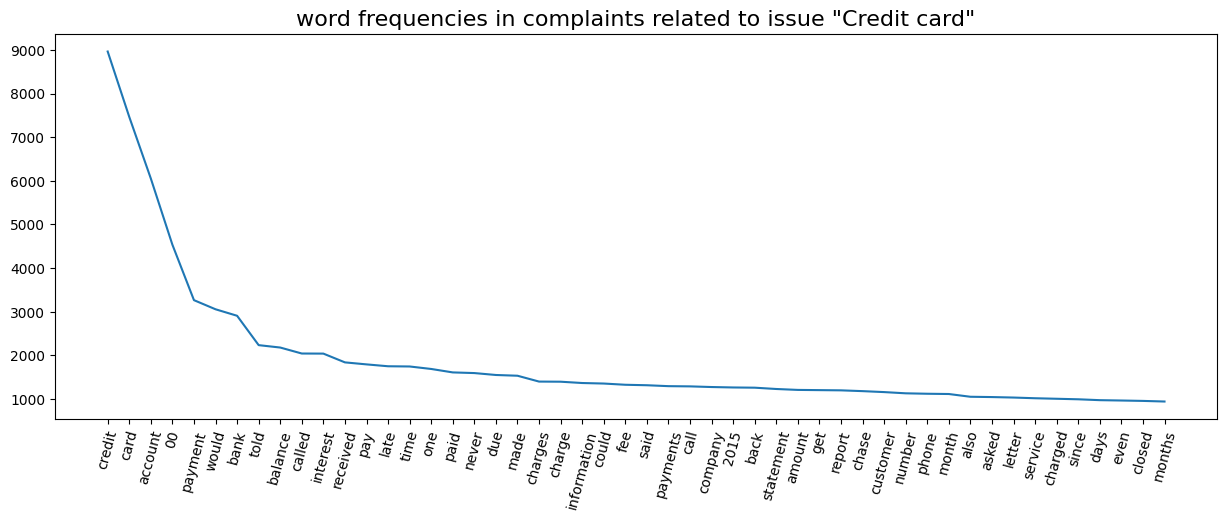

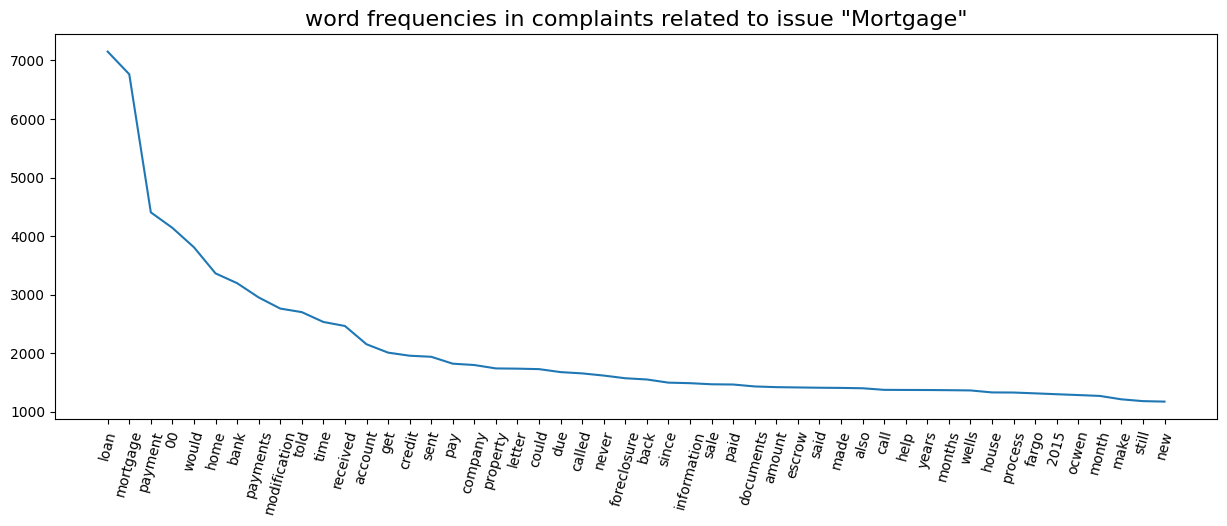

In [23]:
n=50
unique_labels = np.unique(labels)
for label in unique_labels:
    freqs = np.array(tf_tr[y_tr==label].sum(axis=0))[0]
    plt.figure(figsize=(15,5))
    inds = np.argsort(freqs)[::-1]
    plt.plot(freqs[inds[:n]])
    plt.xticks(range(n), np.array(TF_vocabulary)[inds[:n]], rotation=75)
    plt.title('word frequencies in complaints related to issue ' + '"'+label+'"', fontsize=16)

## **TF-IDF**

In [24]:
TFIDF_vectorizer = TfidfVectorizer(max_features=1000, stop_words=stop_words_and_punctuation,
                                   norm='l2')
print(TFIDF_vectorizer)

tfidf_tr = TFIDF_vectorizer.fit_transform(examples_tr)
TFIDF_vocabulary = TFIDF_vectorizer.get_feature_names_out()

TfidfVectorizer(max_features=1000,
                stop_words=['these', 'when', 'have', 'xxxxxxxxxxxxx', '&', 'll',
                            'can', 'couldn', 'after', ';', "isn't", '_', 'with',
                            'myself', 'by', 'we', 'further', 'now', ']',
                            'because', 'don', ')', 'up', 'until',
                            'xxxxxxxxxxxxxxxxx', '`', 'not', 'd', "mustn't",
                            '*', ...])


In [25]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(tfidf_tr, y_tr)

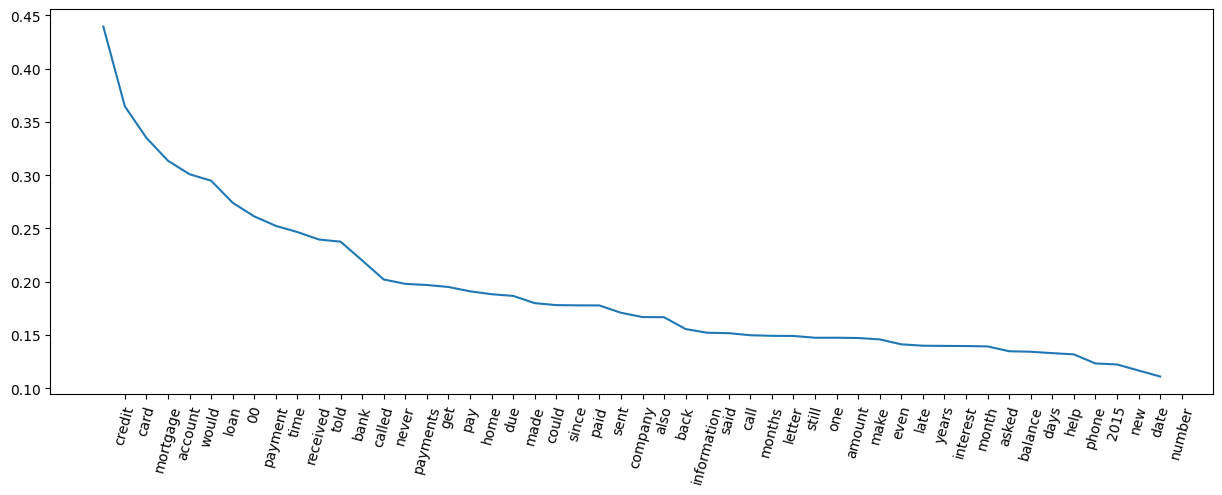

In [26]:
n_more_informative = 500
inds = np.argsort(-mi)
plt.figure(figsize=(15,5))
n_show = 50
plt.plot(mi[inds[:n_show]])
plt.xticks(range(1,1+n_show), np.array(TFIDF_vocabulary)[inds[:n_show]], rotation=75);

## **Principal Component Analysis**

In [27]:
tfidf_tr_dense = np.array(tfidf_tr.todense())

In [28]:
tfidf_tr_dense.shape

(7000, 1000)

In [29]:
tfidf_tr_dense.shape

(7000, 1000)

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_docs = PCA(n_components=100)
sc = StandardScaler()
sc.fit(tfidf_tr_dense)
#aux = sc.transform(tfidf_tr_dense)
aux = tfidf_tr_dense
pca_docs.fit(aux)
doc_vecs_tr  = pca_docs.transform(aux)

pca_words = PCA(n_components=100)
pca_words.fit(aux)
sc2 = StandardScaler()
sc2.fit(tfidf_tr_dense.T)
#aux2 = sc2.transform(tfidf_tr_dense.T)
aux2 = tfidf_tr_dense.T
pca_words.fit(aux2)
word_vecs = pca_words.transform(aux2)

In [31]:
print(doc_vecs_tr.shape)
print(word_vecs.shape)

(7000, 100)
(1000, 100)


In [32]:
from sklearn.preprocessing import normalize
word_vecs_norm   = normalize(word_vecs)
doc_vecs_tr_norm = normalize(doc_vecs_tr)

In [33]:
print(word_vecs_norm.shape)
print(doc_vecs_tr_norm.shape)

(1000, 100)
(7000, 100)


In [34]:
latent_dimension_x = 0
latent_dimension_y = 1

# importing bokeh library for interactive dataviz

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool, LabelSet, ColumnDataSource, Range1d
from bokeh.plotting import figure, show, output_notebook

output_notebook()
p = bp.figure(title="words in latent dimensions", # plot_width=700, plot_height=600,
              tools="pan,wheel_zoom,box_zoom,reset,hover,save",
              x_axis_label='latent dimension {}'.format(latent_dimension_x),
              y_axis_label='latent dimension {}'.format(latent_dimension_y),
              #x_axis_type=None, y_axis_type=None,
              min_border=1)
p.title.text_font_size='16pt'
p.xaxis.axis_label_text_font_style='normal'
p.xaxis.axis_label_text_font_size='16pt'
p.yaxis.axis_label_text_font_style='normal'
p.yaxis.axis_label_text_font_size='16pt'

p.xgrid.visible = False
p.ygrid.visible = False

dictf = {'x':word_vecs_norm[:,latent_dimension_x],
         'y':word_vecs_norm[:,latent_dimension_y],
         'words':TFIDF_vocabulary}
aa = ColumnDataSource(dictf)
p.scatter(x='x', y='y', source=aa)
labels_p = LabelSet(x='x', y='y', text='words', level='glyph',
                    x_offset=5, y_offset=5, source=aa,
                    #render_mode='canvas',
                    text_font_size="8pt")
p.add_layout(labels_p)

hover = p.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(p)

In [35]:
from sklearn.metrics.pairwise import pairwise_distances

index2word = np.array(TFIDF_vocabulary)
word2index = {w:i for i,w in enumerate(index2word)}

def most_similar_words(word,n=10):
    n_latent_dimensions = np.shape(word_vecs_norm)[1]
    ind = word2index[word]
    aux = np.reshape(word_vecs_norm[ind,:], (1,n_latent_dimensions))
    dists = pairwise_distances(aux, word_vecs_norm).flatten()
    inds = dists.argsort().tolist()
    inds.remove(ind)
    return index2word[inds[:n]]

In [36]:
print(word2index['contract'])

236


In [37]:
most_similar_words('claim')

array(['fraud', 'claims', 'proof', 'investigation', 'filed', 'claimed',
       'copy', 'court', 'case', 'documentation'], dtype=object)

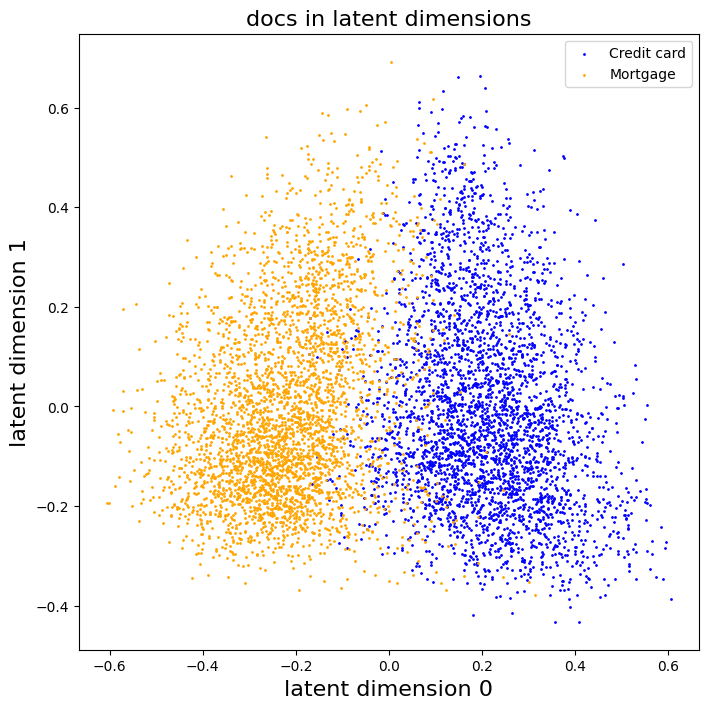

In [38]:
colors = ['blue', 'orange', 'yellow', 'red', 'green', 'magenta']

X_tr = doc_vecs_tr_norm

latent_dimension_x = 0
latent_dimension_y = 1
plt.figure(figsize=(8,8))
for i,label in enumerate(unique_labels):
    plt.scatter(X_tr[y_tr==label,latent_dimension_x],
                X_tr[y_tr==label,latent_dimension_y],
                s = 1, alpha = 1, c = colors[i], label=label,
                )
#plt.axis([-50,50,-50,50])
plt.legend()
plt.xlabel('latent dimension {}'.format(latent_dimension_x), fontsize=16)
plt.ylabel('latent dimension {}'.format(latent_dimension_y), fontsize=16)
plt.title('docs in latent dimensions', fontsize=16);

In [39]:
latent_dimension_x = 0
latent_dimension_y = 1

# defining the chart
output_notebook()
p = bp.figure(title="docs in latent dimensions", # plot_width=700, plot_height=600,
              tools="pan,wheel_zoom,box_zoom,reset,hover,save",
              x_axis_label='latent dimension {}'.format(latent_dimension_x),
              y_axis_label='latent dimension {}'.format(latent_dimension_y),
              #x_axis_type=None, y_axis_type=None,
              min_border=1)
p.title.text_font_size = '16pt'
p.xaxis.axis_label_text_font_style='normal'
p.xaxis.axis_label_text_font_size='16pt'
p.yaxis.axis_label_text_font_style='normal'
p.yaxis.axis_label_text_font_size='16pt'

p.xgrid.visible = False
p.ygrid.visible = False

colores = np.array(len(X_tr)*[colors[0]], dtype=object)
for i,label in enumerate(unique_labels):
    colores[y_tr==label] = colors[i]
dictf = {'x':X_tr[:,latent_dimension_x],
         'y':X_tr[:,latent_dimension_y],
         'narratives':[narrative[:200] for narrative in narratives_tr],
         'clases':y_tr,
         'c':colores
         }
aa = ColumnDataSource(dictf)
p.scatter(x='x', y='y',
          color='c',
          #legend='clases',
          #alpha=0.05,
          source=aa
)

hover = p.select(dict(type=HoverTool))
hover.tooltips={"Class": "@clases",
                "Complaint (first lines)": "@narratives", }
show(p)

In [40]:
def most_similar_docs(doc_ind,n=10):
    n_latent_dimensions = np.shape(word_vecs_norm)[1]
    aux = np.reshape(doc_vecs_tr_norm[doc_ind,:], (1,n_latent_dimensions))
    dists = pairwise_distances(aux, doc_vecs_tr_norm).flatten()
    inds = dists.argsort().tolist()
    inds.remove(doc_ind)
    return inds[:n]

In [41]:
doc_ind = 1
doc_inds = most_similar_docs(doc_ind)

start_bold = '\033[1m'
end_bold   = '\033[0m'

print(start_bold + "document {} in training:".format(doc_ind) + end_bold)
print(narratives_tr[doc_ind])
print(start_bold + "Most similar documents in training:" + end_bold)
for i,ind in enumerate(doc_inds):
    print(start_bold + "* doc {} in training:".format(i) + end_bold)
    print(narratives_tr[ind])

document 1 in training:
MY NAME IS XXXX XXXX, XXXX EXECUTOR FOR THE ESTATE OF XXXX XXXX # XXXX wells fargo servicer has repeatedly stone walled any attempts by me to access their policies and programs related to regulation z dodd frank successor- in-interest. I am the heir and successor-in-interest to property left to me by my mother. I have contacted wells fargo numerous times about being placed on the mortgage loan and allowed to make payments they have continued to try and force me to do a modification, refinance or assumption. i have provided them with documents from the CFPB that explains the successor-in-interest, they have ignored this information and continue to try to subject me XXXX.. I am asking CFPB to demand/command wells fargo explain why they say these policy and procedures dont exist.They have caused a significant financial burden and lost of time trying to deal with a organization that intends to wait me out and foreclose on this property. My complaint is simply that w